# 1. Loading Data and Packages


In [155]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [156]:
df = pd.read_csv('2019_hdb_dataset_with_mrt_schools_sm.csv')
# df = df.drop(columns = ['Unnamed: 0','Latitude','Longtitude','Year','address','nearest_mrt','nearest_primary_school','nearest_secondary_school','nearest_JC/MI','nearest_mixed_level','nearest_sm','Postal','remaining_lease','full_address'])
df = df.drop(columns = ['Unnamed: 0','Year','address','Postal','full_address'])
df['remaining_lease'] = 99 - (2019 - df['lease_commence_date'])
df['flat_type_model'] = df['flat_type']+' '+df['flat_model']
df = df.drop(columns = ['flat_type','flat_model'])

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22186 entries, 0 to 22185
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   town                          22186 non-null  object 
 1   storey_range                  22186 non-null  object 
 2   floor_area_sqm                22186 non-null  float64
 3   lease_commence_date           22186 non-null  int64  
 4   remaining_lease               22186 non-null  int64  
 5   resale_price                  22186 non-null  float64
 6   Latitude                      22186 non-null  float64
 7   Longtitude                    22186 non-null  float64
 8   nearest_mrt                   22186 non-null  object 
 9   nearest_mrt_distance(km)      22186 non-null  float64
 10  nearest_primary_school        22186 non-null  object 
 11  nearest_primary_school(km)    22186 non-null  float64
 12  nearest_secondary_school      22186 non-null  object 
 13  n

In [158]:
x = df
y = df['flat_type_model']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2,
random_state = 1)
train = x_train
test = x_test

In [159]:
train['Id'] = [i for i in range(len(x_train))]
test['Id'] =[i for i in range(len(x_test))]
# why do i care about the town or block if I know the town and storey range?
# train = train.drop(columns = ['town','flat_type','storey_range','nearest_mrt','nearest_primary_school','nearest_secondary_school','nearest_JC/MI','nearest_mixed_level','nearest_sm'])
# test = test.drop(columns = ['town','flat_type','storey_range','nearest_mrt','nearest_primary_school','nearest_secondary_school','nearest_JC/MI','nearest_mixed_level','nearest_sm'])

In [160]:
train.head()

,town,storey_range,floor_area_sqm,lease_commence_date,remaining_lease,resale_price,Latitude,Longtitude,nearest_mrt,nearest_mrt_distance(km),...,nearest_secondary_school,nearest_secondary_school(km),nearest_JC/MI,nearest_JC/MI(km),nearest_mixed_level,nearest_mixed_level(km),nearest_sm,nearest_sm_distance(km),flat_type_model,Id
9446,MARINE PARADE,07 TO 09,65.000,1975,55,345000.000,1.305,103.915,KEMBANGAN MRT STATION,1.842,...,CHIJ KATONG CONVENT,0.378,VICTORIA JUNIOR COLLEGE,0.515,TEMASEK JUNIOR COLLEGE,2.757,COLD STORAGE SINGAPORE (1983) PTE LTD,0.125,3 ROOM Improved,0
13133,HOUGANG,04 TO 06,84.000,1986,66,320000.000,1.370,103.886,HOUGANG MRT STATION,0.700,...,XINMIN SECONDARY SCHOOL,0.435,NANYANG JUNIOR COLLEGE,3.108,MARIS STELLA HIGH SCHOOL,3.324,COLD STORAGE SINGAPORE (1983) PTE LTD,0.339,4 ROOM Simplified,1
8202,WOODLANDS,01 TO 03,84.000,1989,69,290000.000,1.432,103.781,MARSILING MRT STATION,0.736,...,FUCHUN SECONDARY SCHOOL,0.403,YISHUN INNOVA JUNIOR COLLEGE,5.507,SINGAPORE SPORTS SCHOOL,1.141,NTUC Fairprice Co-operative Ltd,0.269,4 ROOM Simplified,2
10180,WOODLANDS,04 TO 06,104.000,1996,76,328000.000,1.427,103.773,MARSILING MRT STATION,0.664,...,FUCHUN SECONDARY SCHOOL,0.660,JURONG PIONEER JUNIOR COLLEGE,5.104,SINGAPORE SPORTS SCHOOL,1.835,SHENG SIONG SUPERMARKET PTE LTD,0.544,4 ROOM Model A,3
13327,JURONG WEST,13 TO 15,129.000,1993,73,425000.000,1.346,103.697,PIONEER MRT STATION,0.972,...,BOON LAY SECONDARY SCHOOL,0.670,MILLENNIA INSTITUTE,5.034,RIVER VALLEY HIGH SCHOOL,1.312,COLD STORAGE SINGAPORE (1983) PTE LTD,0.515,5 ROOM Improved,4


In [161]:
test.head()

,town,storey_range,floor_area_sqm,lease_commence_date,remaining_lease,resale_price,Latitude,Longtitude,nearest_mrt,nearest_mrt_distance(km),...,nearest_secondary_school,nearest_secondary_school(km),nearest_JC/MI,nearest_JC/MI(km),nearest_mixed_level,nearest_mixed_level(km),nearest_sm,nearest_sm_distance(km),flat_type_model,Id
21265,PASIR RIS,01 TO 03,110.000,1989,69,400000.000,1.375,103.958,PASIR RIS MRT STATION,1.003,...,PASIR RIS CREST SECONDARY SCHOOL,0.343,TAMPINES MERIDIAN JUNIOR COLLEGE,2.282,TEMASEK JUNIOR COLLEGE,6.743,RAW MARKET PTE. LTD.,0.321,4 ROOM Model A,0
13904,TAMPINES,01 TO 03,103.000,1985,65,445000.000,1.353,103.948,TAMPINES MRT STATION,0.339,...,PASIR RIS SECONDARY SCHOOL,0.216,TAMPINES MERIDIAN JUNIOR COLLEGE,2.901,TEMASEK JUNIOR COLLEGE,4.040,NTUC Fairprice Co-operative Ltd,0.371,4 ROOM Model A,1
8024,TAMPINES,13 TO 15,73.000,1984,64,350000.000,1.349,103.940,TAMPINES WEST MRT STATION,0.365,...,ST. HILDA'S SECONDARY SCHOOL,0.378,TAMPINES MERIDIAN JUNIOR COLLEGE,3.119,TEMASEK JUNIOR COLLEGE,3.362,COLD STORAGE SINGAPORE (1983) PTE LTD,0.522,3 ROOM Model A,2
153,BEDOK,10 TO 12,150.000,1985,65,670000.000,1.331,103.909,KAKI BUKIT MRT STATION,0.476,...,MANJUSRI SECONDARY SCHOOL,0.846,VICTORIA JUNIOR COLLEGE,3.010,TEMASEK JUNIOR COLLEGE,3.280,CHUA & NG PTE. LTD.,0.621,EXECUTIVE Maisonette,3
21319,PUNGGOL,13 TO 15,68.000,2016,96,385000.000,1.404,103.895,SOO TECK LRT STATION,0.255,...,EDGEFIELD SECONDARY SCHOOL,0.870,TAMPINES MERIDIAN JUNIOR COLLEGE,5.584,MARIS STELLA HIGH SCHOOL,7.177,U STARS SUPERMARKET PTE. LTD.,0.245,3 ROOM Model A,4


In [162]:
# Check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

# Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

# Now drop the 'Id' column since it's unnecessary for the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# Check data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (17748, 22) 
The test data size before dropping Id feature is : (4438, 22) 

The train data size after dropping Id feature is : (17748, 21) 
The test data size after dropping Id feature is : (4438, 21) 


# 2. Analyzing the Test Variable (Sale Price)


In [163]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train['resale_price'].describe()

count     17748.000
mean     432758.570
std      153751.475
min      160000.000
25%      320000.000
50%      402000.000
75%      510000.000
max     1205000.000
Name: resale_price, dtype: float64


 mu = 432758.57 and sigma = 153747.14



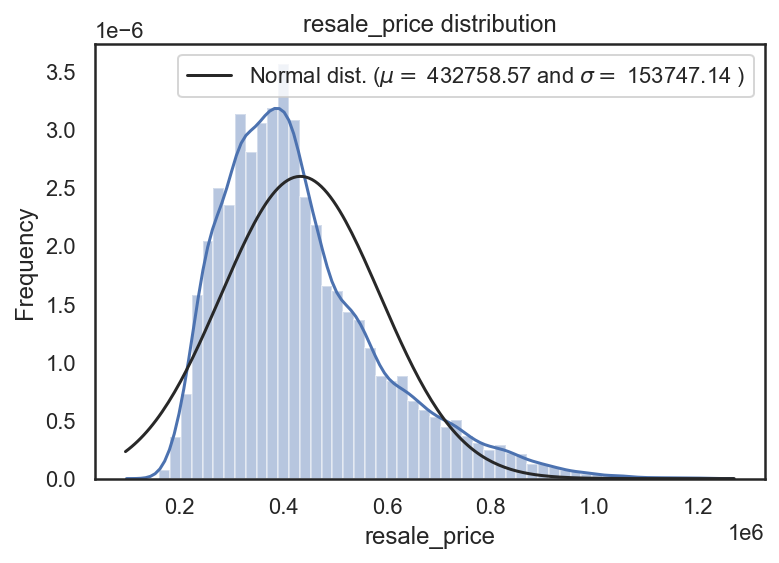

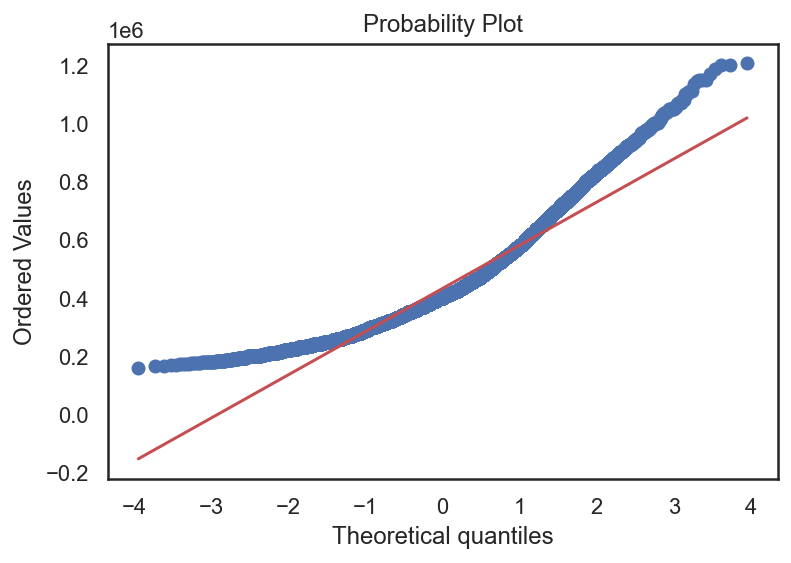

Skewness: 1.097834
Kurtosis: 1.296419


In [164]:
# Plot Histogram
sns.distplot(train['resale_price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['resale_price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('resale_price distribution')

fig = plt.figure()
res = stats.probplot(train['resale_price'], plot=plt)
plt.show()

print("Skewness: %f" % train['resale_price'].skew())
print("Kurtosis: %f" % train['resale_price'].kurt())

# 3. Multivariable Analysis

In [165]:
# Checking Categorical Data
train.select_dtypes(include=['object']).columns

Index(['town', 'storey_range', 'nearest_mrt', 'nearest_primary_school',
       'nearest_secondary_school', 'nearest_JC/MI', 'nearest_mixed_level',
       'nearest_sm', 'flat_type_model'],
      dtype='object')

In [166]:
# Checking Numerical Data
train.select_dtypes(include=['int64','float64']).columns

Index(['floor_area_sqm', 'lease_commence_date', 'remaining_lease',
       'resale_price', 'Latitude', 'Longtitude', 'nearest_mrt_distance(km)',
       'nearest_primary_school(km)', 'nearest_secondary_school(km)',
       'nearest_JC/MI(km)', 'nearest_mixed_level(km)',
       'nearest_sm_distance(km)'],
      dtype='object')

In [167]:
cat = len(train.select_dtypes(include=['object']).columns)
num = len(train.select_dtypes(include=['int64','float64']).columns)
print('Total Features: ', cat, 'categorical', '+',
      num, 'numerical', '=', cat+num, 'features')

Total Features:  9 categorical + 12 numerical = 21 features


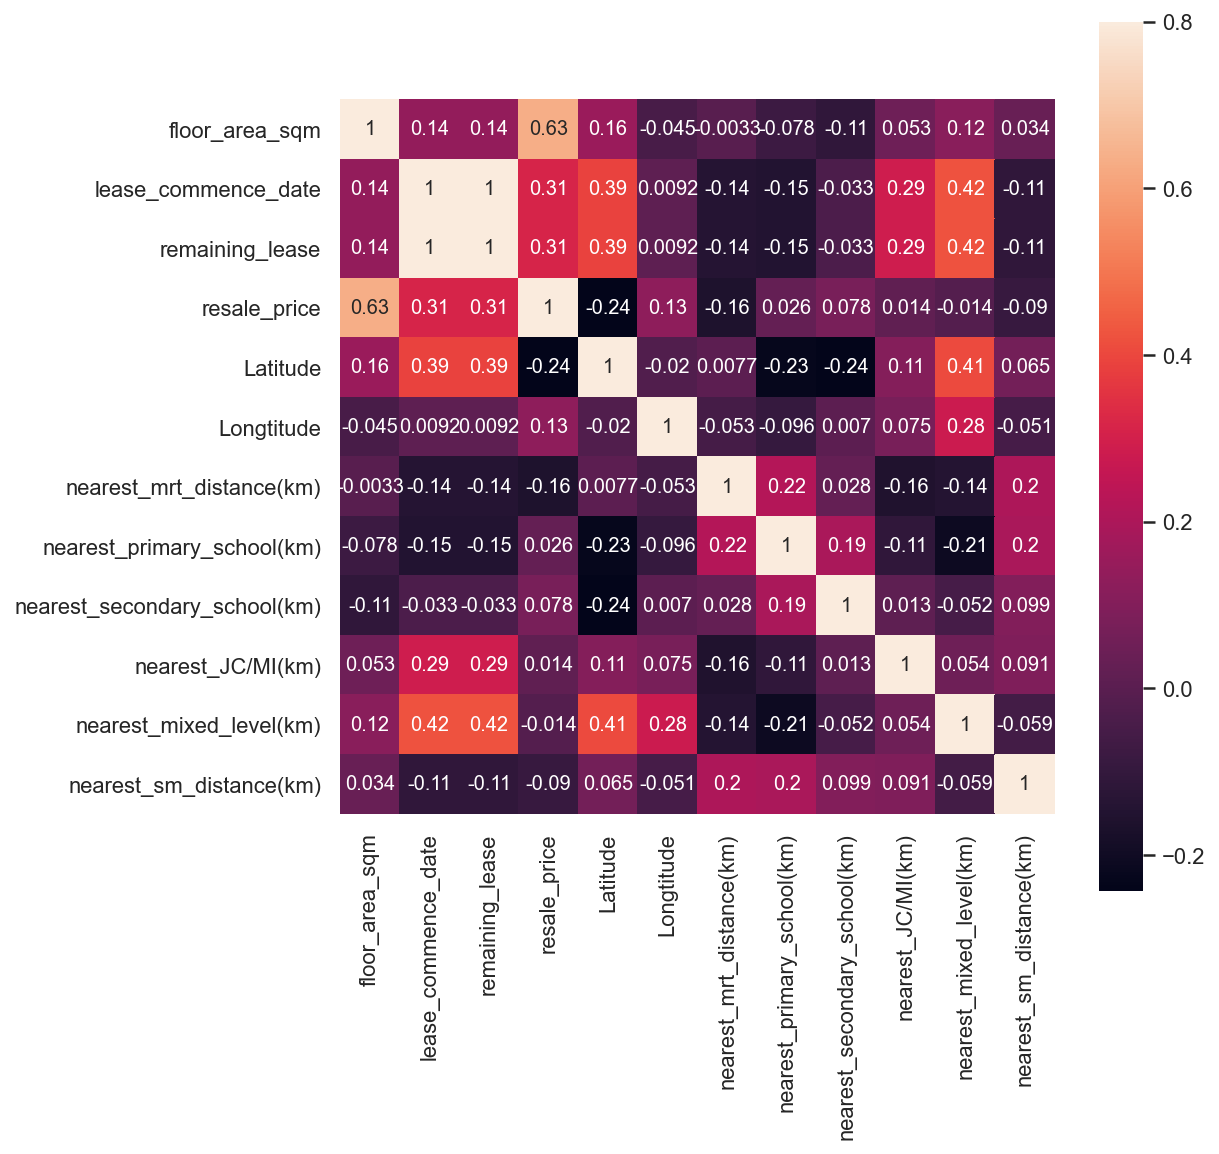

In [168]:
# Correlation Matrix Heatmap
corrmat = train.corr()
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corrmat, vmax=.8, square=True, annot = True);

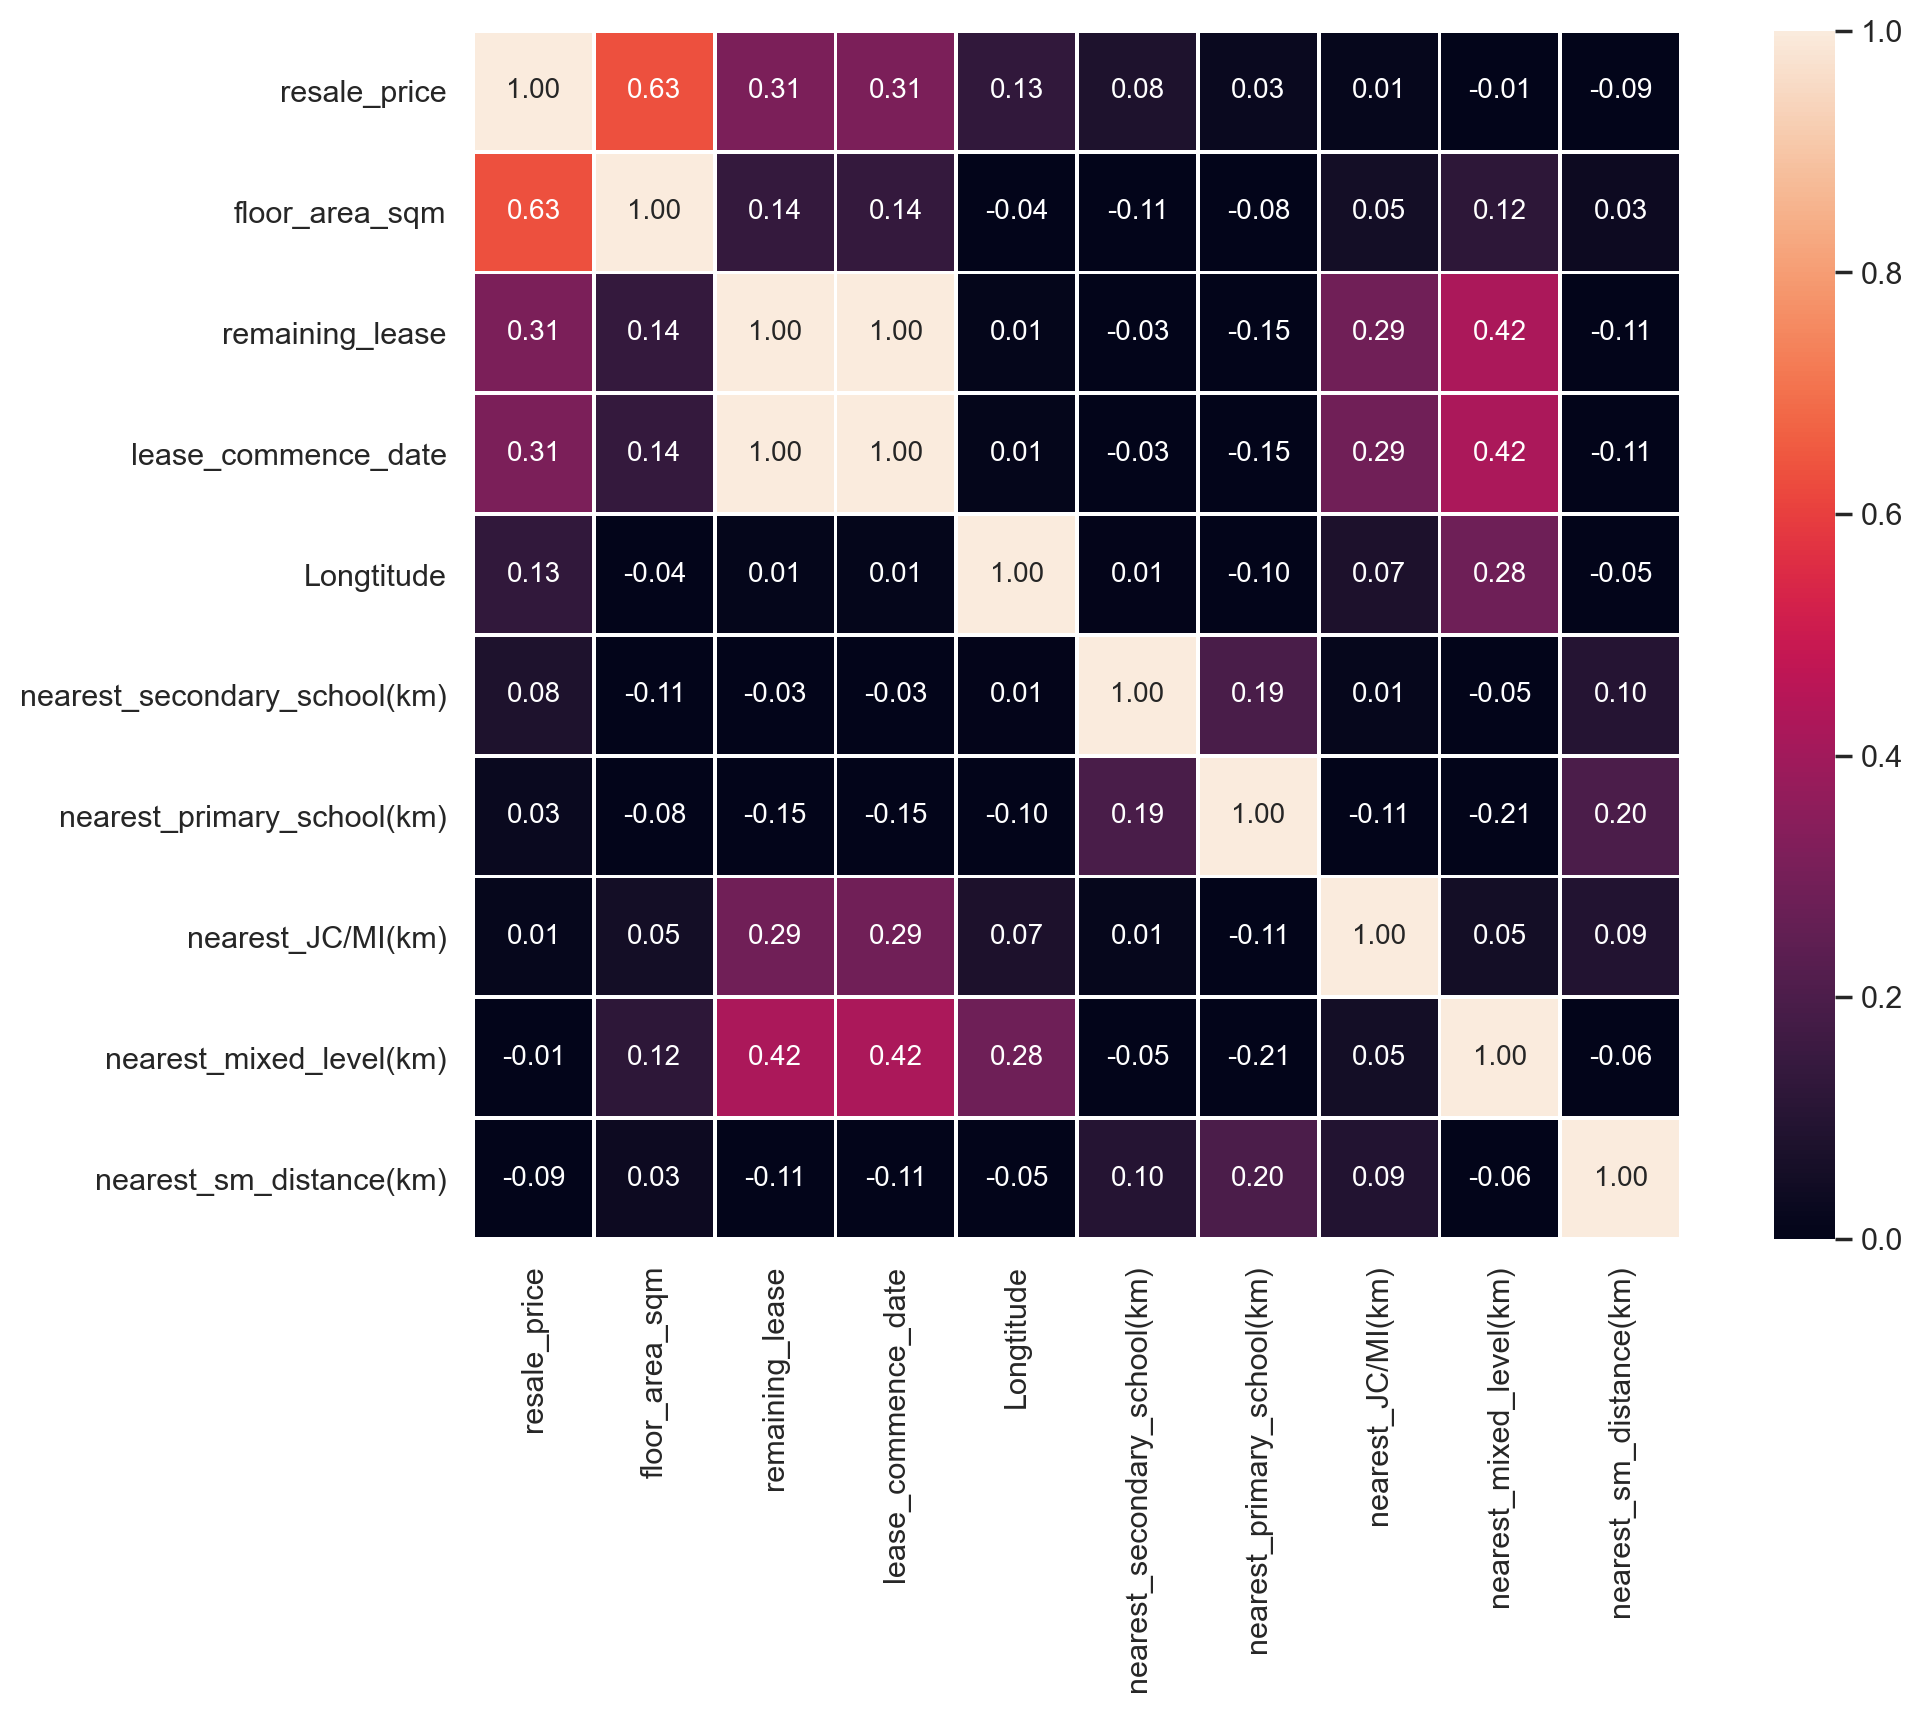

In [169]:
# Top 10 Heatmap
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'resale_price')['resale_price'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(
    context     = 'notebook', 
    style       = 'white',
    palette     = 'deep',
    font        = 'sans-serif',
    font_scale  = 1,
    color_codes = True,
    rc          = {'figure.figsize':(12,8),
                   'figure.dpi': 100}
)
sns.heatmap(cm, vmin=0, vmax=1, cbar=True, annot=True, linewidths= 1, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)



In [170]:
most_corr = pd.DataFrame(cols)
most_corr.columns = ['Most Correlated Features']
most_corr

,Most Correlated Features
0,resale_price
1,floor_area_sqm
2,remaining_lease
3,lease_commence_date
4,Longtitude
5,nearest_secondary_school(km)
6,nearest_primary_school(km)
7,nearest_JC/MI(km)
8,nearest_mixed_level(km)
9,nearest_sm_distance(km)


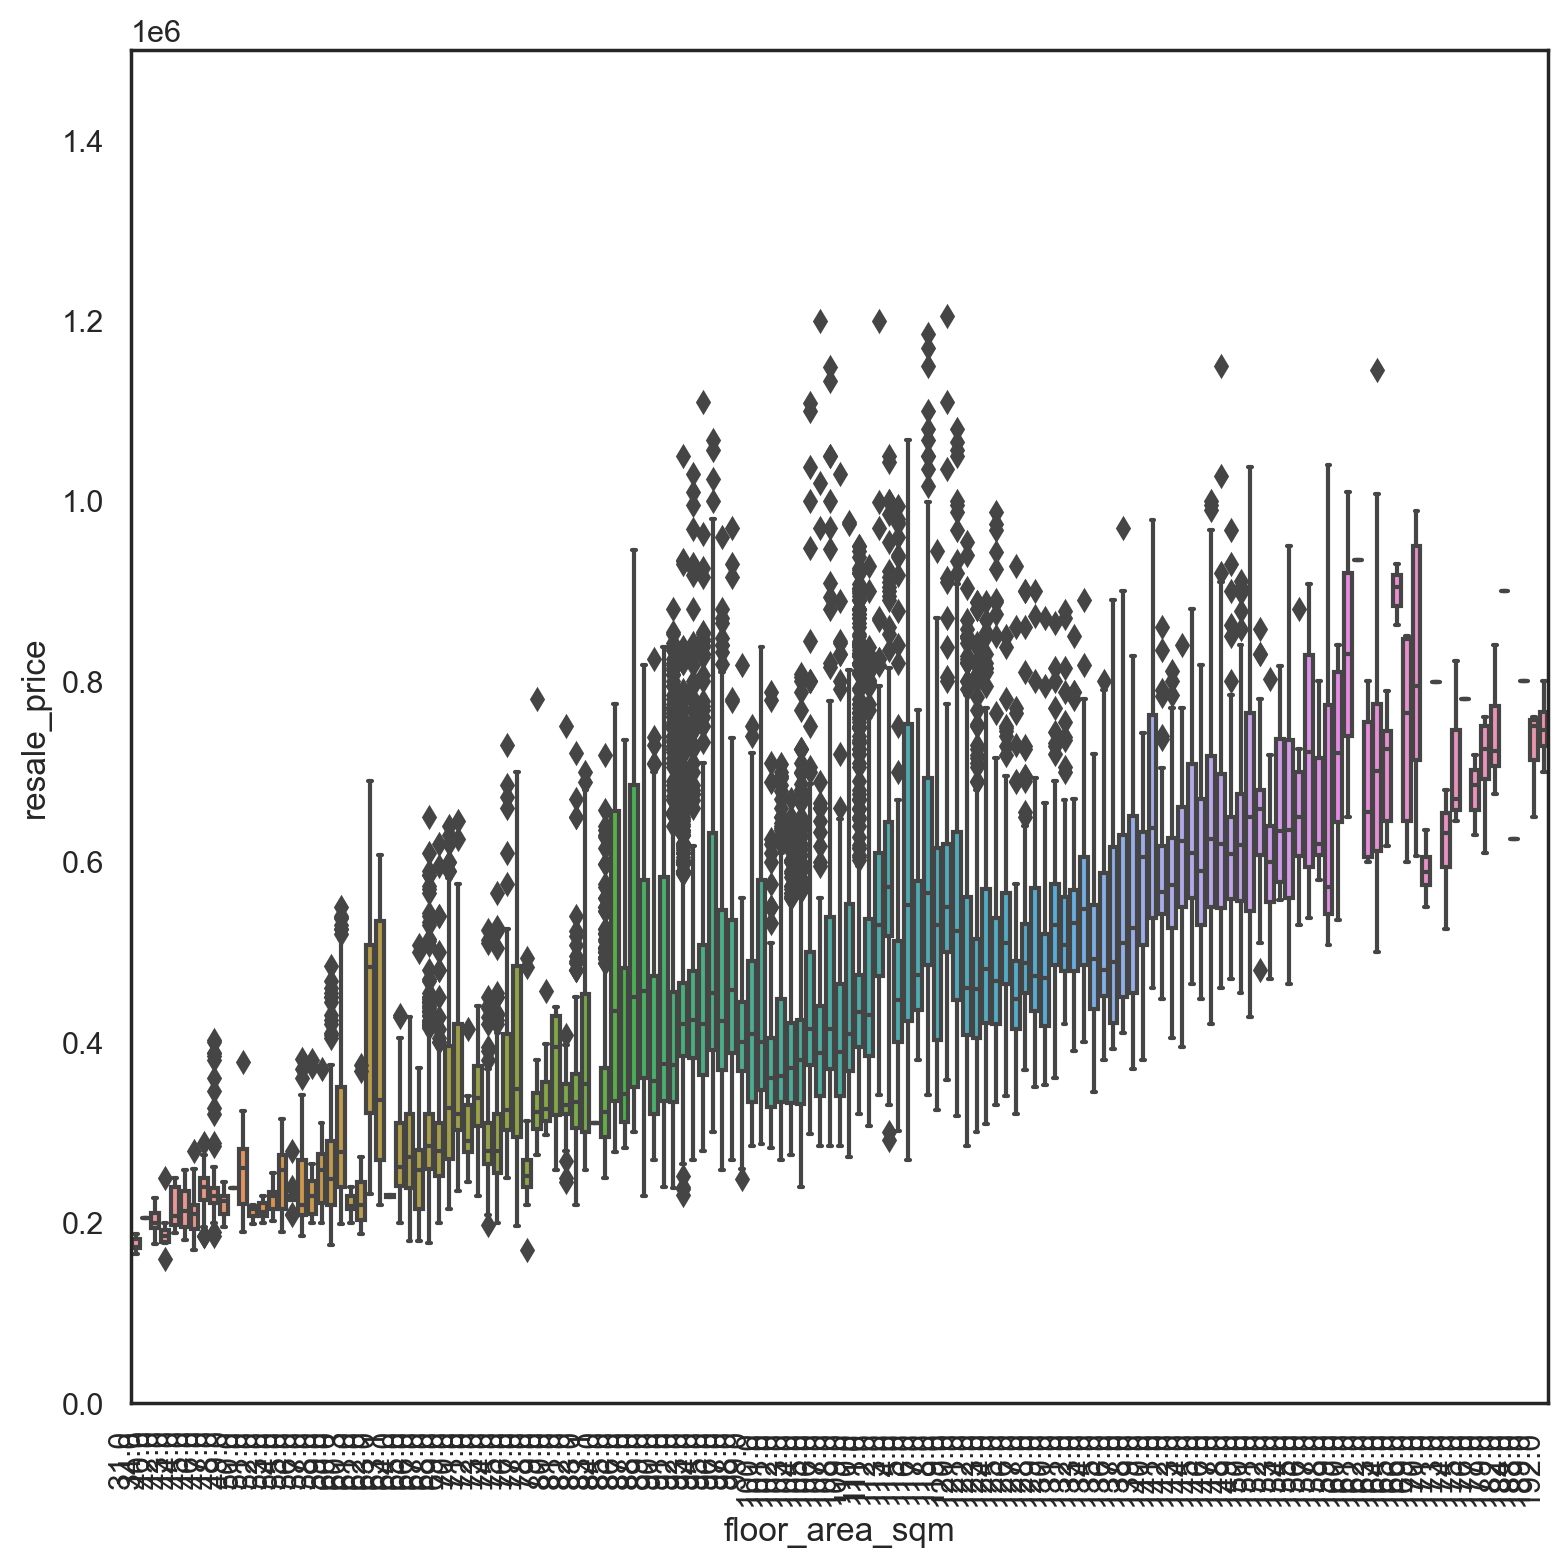

In [171]:
#  floor_area_sqm vs resale_price
var = 'floor_area_sqm'
data = pd.concat([train['resale_price'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 8))
fig = sns.boxplot(x=var, y="resale_price", data=data)
fig.axis(ymin=0, ymax=1500000);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

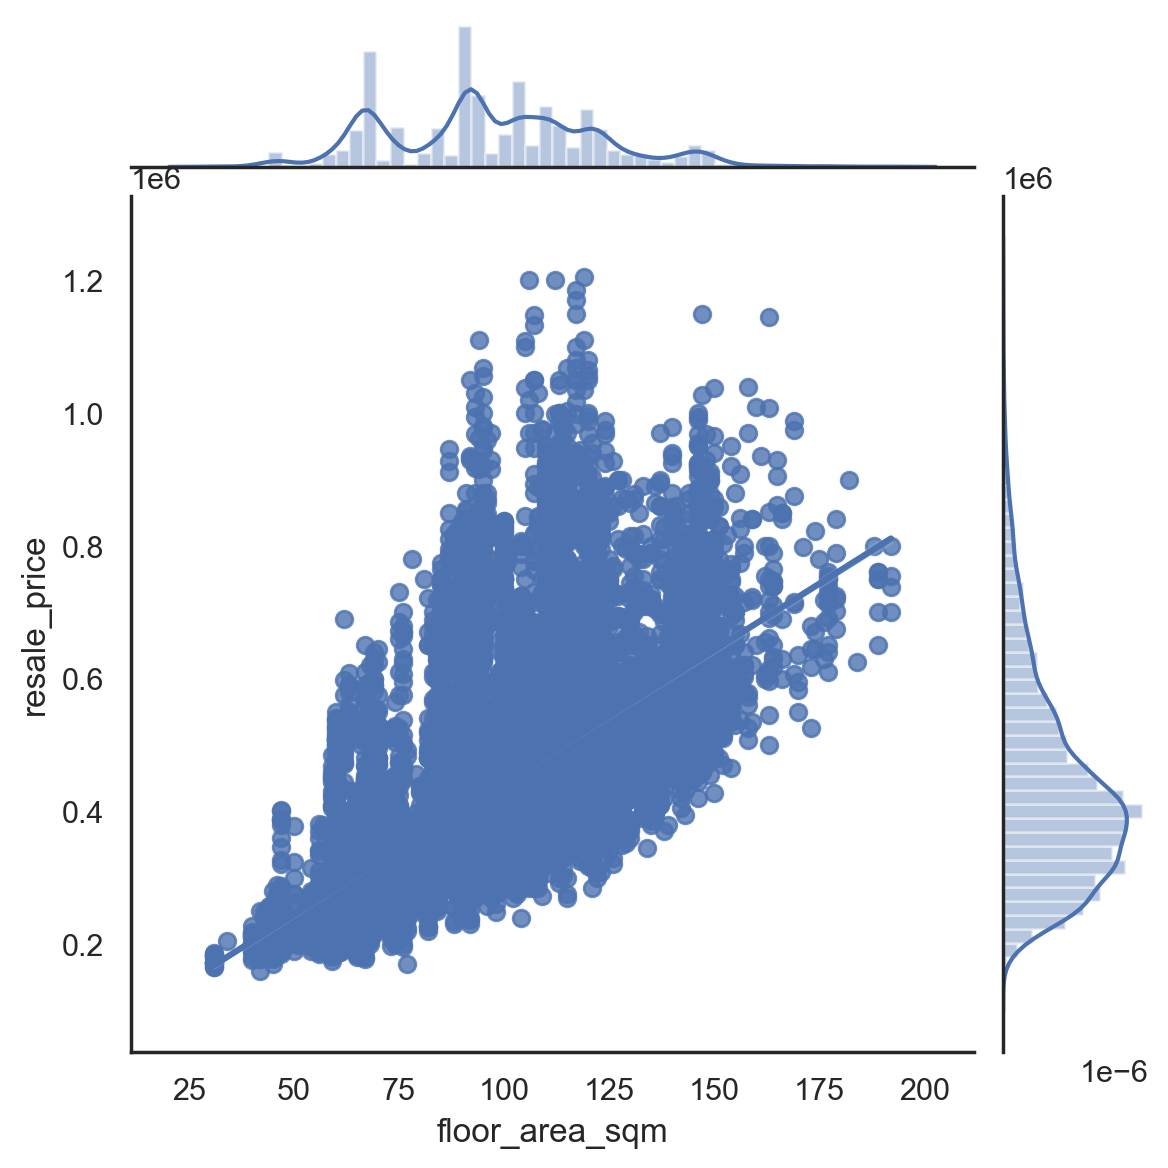

In [172]:
#  floor_area_sqm vs resale_price
sns.jointplot(x=train['floor_area_sqm'], y=train['resale_price'], kind='reg')

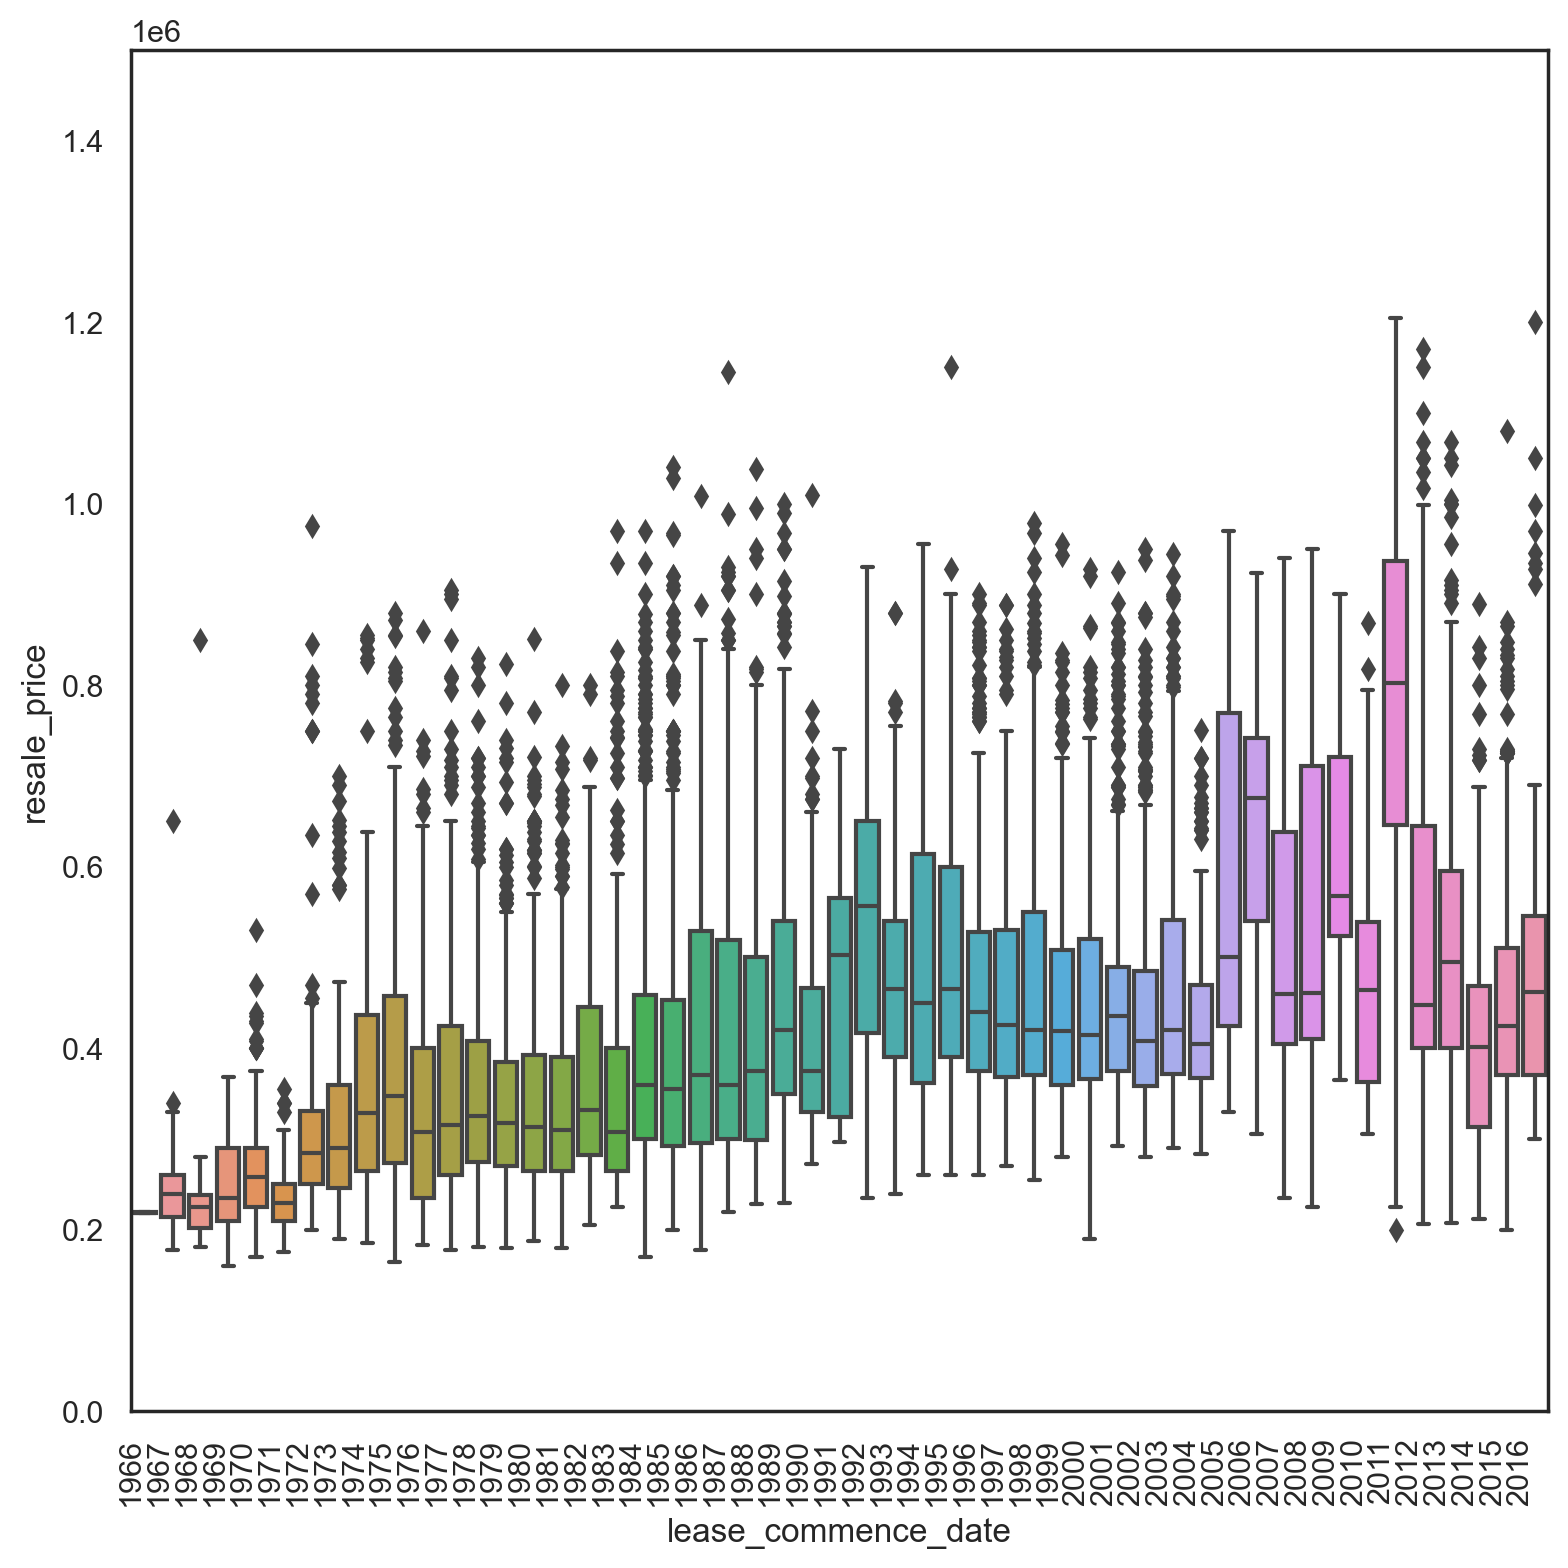

In [173]:
#  lease_commence_date vs resale_price
var = 'lease_commence_date'
data = pd.concat([train['resale_price'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 8))
fig = sns.boxplot(x=var, y="resale_price", data=data)
fig.axis(ymin=0, ymax=1500000);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

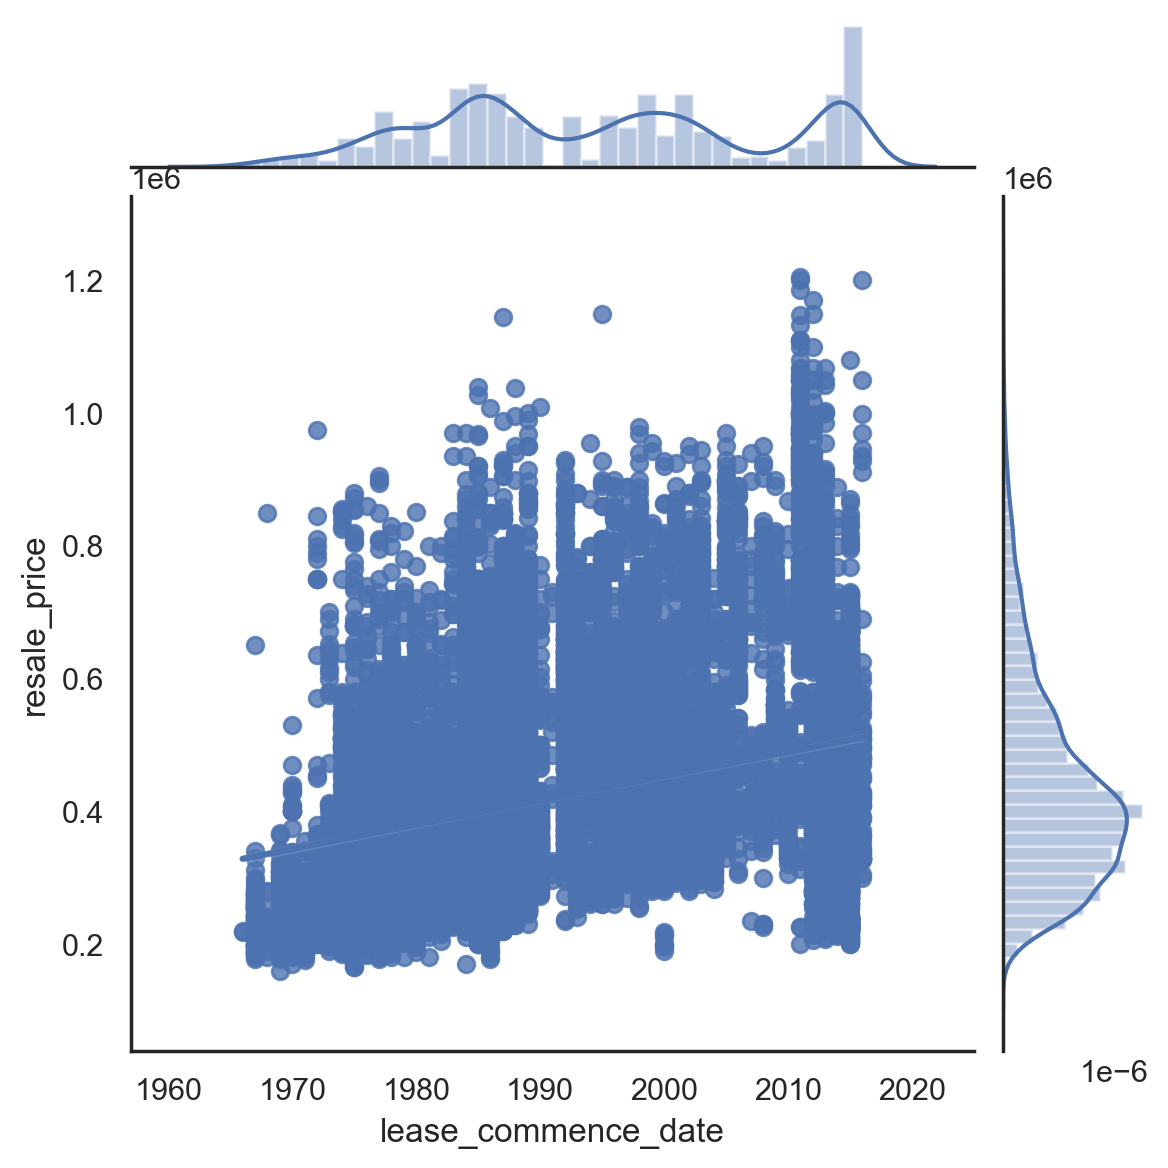

In [174]:
#  lease_commence_date vs resale_price
sns.jointplot(x=train['lease_commence_date'], y=train['resale_price'], kind='reg')

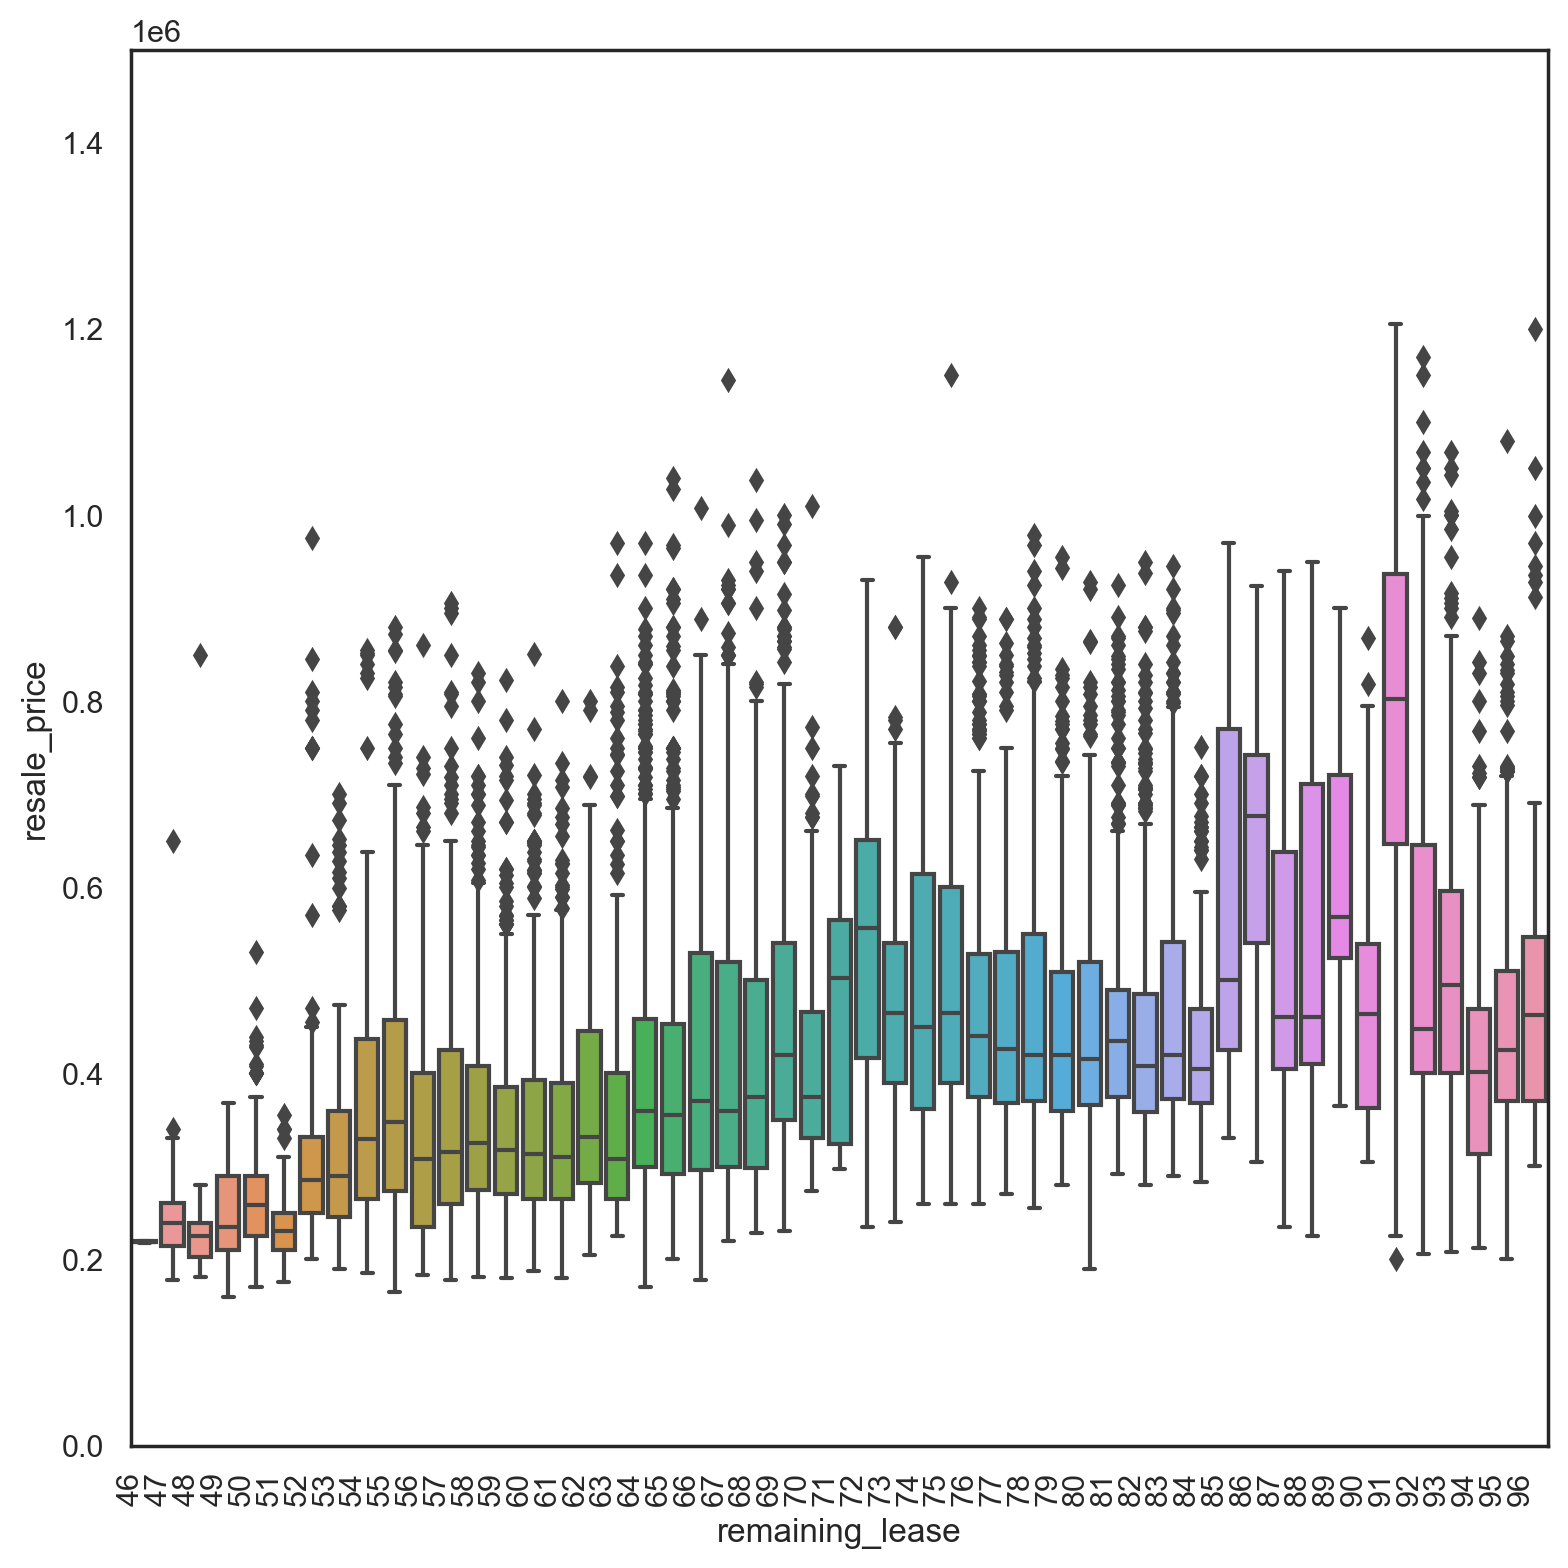

In [175]:
#  remaining_lease vs resale_price
var = 'remaining_lease'
data = pd.concat([train['resale_price'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 8))
fig = sns.boxplot(x=var, y="resale_price", data=data)
fig.axis(ymin=0, ymax=1500000);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

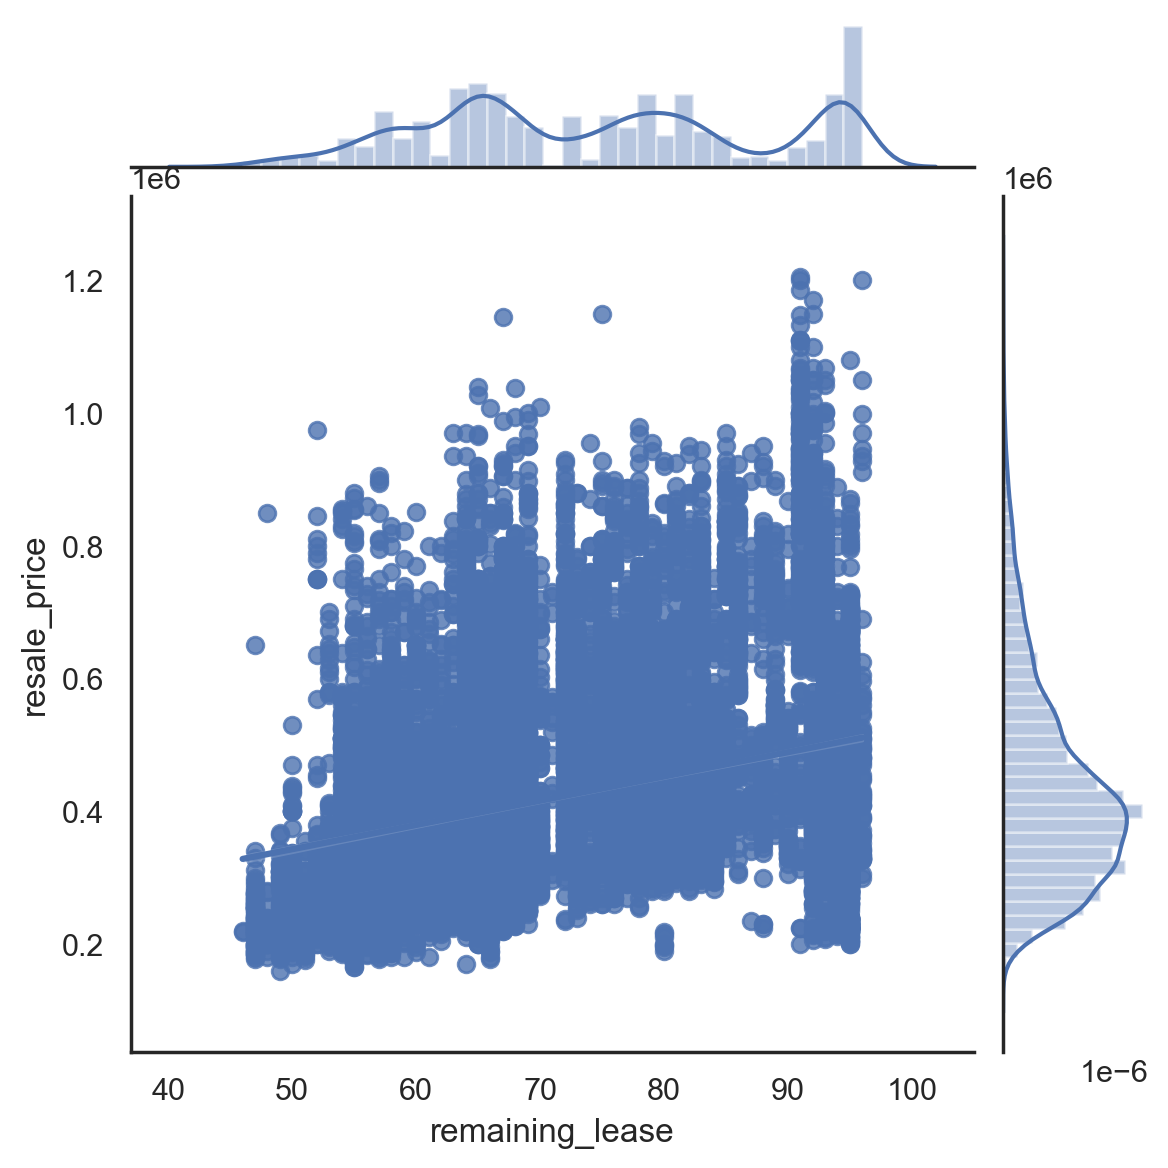

In [176]:
#  remaining_years vs resale_price
sns.jointplot(x=train['remaining_lease'], y=train['resale_price'], kind='reg')

# Impute Missing Data and Clean Data

In [177]:
# Combining Datasets
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.resale_price.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['resale_price'], axis=1, inplace=True)
print("Train data size is : {}".format(train.shape))
print("Test data size is : {}".format(test.shape))
print("Combined dataset size is : {}".format(all_data.shape))

Train data size is : (17748, 21)
Test data size is : (4438, 21)
Combined dataset size is : (22186, 20)


In [178]:
# Find Missing Ratio of Dataset
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio


# Feature Transformation/Engineering


In [179]:
all_data['flat_type_model'].describe()

count              22186
unique                40
top       4 ROOM Model A
freq                5628
Name: flat_type_model, dtype: object

In [180]:
all_data['town'].unique()
all_data['town'] = all_data['town'].map({'ANG MO KIO':'North_East',
                             'BEDOK': 'East',
                             'BISHAN':'Central',
                             'BUKIT BATOK':'West',
                             'BUKIT MERAH':'Central',                 
                             'BUKIT PANJANG':'West',
                             'BUKIT TIMAH':'Central',
                             'CENTRAL AREA':'Central',
                             'CHOA CHU KANG':'West',
                             'CLEMENTI':'West',
                             'GEYLANG':'Central',
                             'HOUGANG':'North_East',
                             'JURONG EAST':'West',
                             'JURONG WEST':'West',
                             'KALLANG/WHAMPOA':'Central',
                             'MARINE PARADE':'Central',
                             'PASIR RIS': 'East',
                             'PUNGGOL':'North_East',
                             'QUEENSTOWN':'Central',
                             'SEMBAWANG': 'North',
                             'SENGKANG':'North_East',
                             'SERANGOON':'North_East',
                             'TAMPINES': 'East',
                             'TOA PAYOH':'Central',
                             'WOODLANDS': 'North',
                             'YISHUN': 'North'})
# df['town_region_encoded'] = df['town_region'].map({'West':1,'North':2, 'North_East':3,'East':4,'Central':5})

all_data['storey_range'].unique()
all_data['storey_range'] = all_data['storey_range'].map({
                                        '10 TO 12':1,
                                        '01 TO 03':2,
                                        '04 TO 06':3,
                                        '07 TO 09':4,
                                        '13 TO 15':5,
                                        '19 TO 21':6,
                                        '22 TO 24':7,
                                        '16 TO 18':8,
                                        '34 TO 36':9,
                                        '28 TO 30':10,
                                        '37 TO 39':11,
                                        '49 TO 51':12,
                                        '25 TO 27':13,
                                        '40 TO 42':14,
                                        '31 TO 33':15,
                                        '46 TO 48':16,
                                        '43 TO 45':17})

In [181]:
# from sklearn.preprocessing import LabelEncoder
# # Process columns and apply LabelEncoder to categorical features
# lbl = LabelEncoder() 
# lbl.fit(list(all_data['storey_range'].values)) 
# all_data['storey_range'] = lbl.transform(list(all_data['storey_range'].values))

# # Check shape        
# print('Shape all_data: {}'.format(all_data.shape))

In [182]:
all_data.head()

,town,storey_range,floor_area_sqm,lease_commence_date,remaining_lease,Latitude,Longtitude,nearest_mrt,nearest_mrt_distance(km),nearest_primary_school,nearest_primary_school(km),nearest_secondary_school,nearest_secondary_school(km),nearest_JC/MI,nearest_JC/MI(km),nearest_mixed_level,nearest_mixed_level(km),nearest_sm,nearest_sm_distance(km),flat_type_model
0,Central,4,65.000,1975,55,1.305,103.915,KEMBANGAN MRT STATION,1.842,NGEE ANN PRIMARY SCHOOL,0.290,CHIJ KATONG CONVENT,0.378,VICTORIA JUNIOR COLLEGE,0.515,TEMASEK JUNIOR COLLEGE,2.757,COLD STORAGE SINGAPORE (1983) PTE LTD,0.125,3 ROOM Improved
1,North_East,3,84.000,1986,66,1.370,103.886,HOUGANG MRT STATION,0.700,XINMIN PRIMARY SCHOOL,0.370,XINMIN SECONDARY SCHOOL,0.435,NANYANG JUNIOR COLLEGE,3.108,MARIS STELLA HIGH SCHOOL,3.324,COLD STORAGE SINGAPORE (1983) PTE LTD,0.339,4 ROOM Simplified
2,North,2,84.000,1989,69,1.432,103.781,MARSILING MRT STATION,0.736,FUCHUN PRIMARY SCHOOL,0.302,FUCHUN SECONDARY SCHOOL,0.403,YISHUN INNOVA JUNIOR COLLEGE,5.507,SINGAPORE SPORTS SCHOOL,1.141,NTUC Fairprice Co-operative Ltd,0.269,4 ROOM Simplified
3,North,3,104.000,1996,76,1.427,103.773,MARSILING MRT STATION,0.664,FUCHUN PRIMARY SCHOOL,0.732,FUCHUN SECONDARY SCHOOL,0.660,JURONG PIONEER JUNIOR COLLEGE,5.104,SINGAPORE SPORTS SCHOOL,1.835,SHENG SIONG SUPERMARKET PTE LTD,0.544,4 ROOM Model A
4,West,5,129.000,1993,73,1.346,103.697,PIONEER MRT STATION,0.972,PIONEER PRIMARY SCHOOL,0.322,BOON LAY SECONDARY SCHOOL,0.670,MILLENNIA INSTITUTE,5.034,RIVER VALLEY HIGH SCHOOL,1.312,COLD STORAGE SINGAPORE (1983) PTE LTD,0.515,5 ROOM Improved



 mu = 12.92 and sigma = 0.34



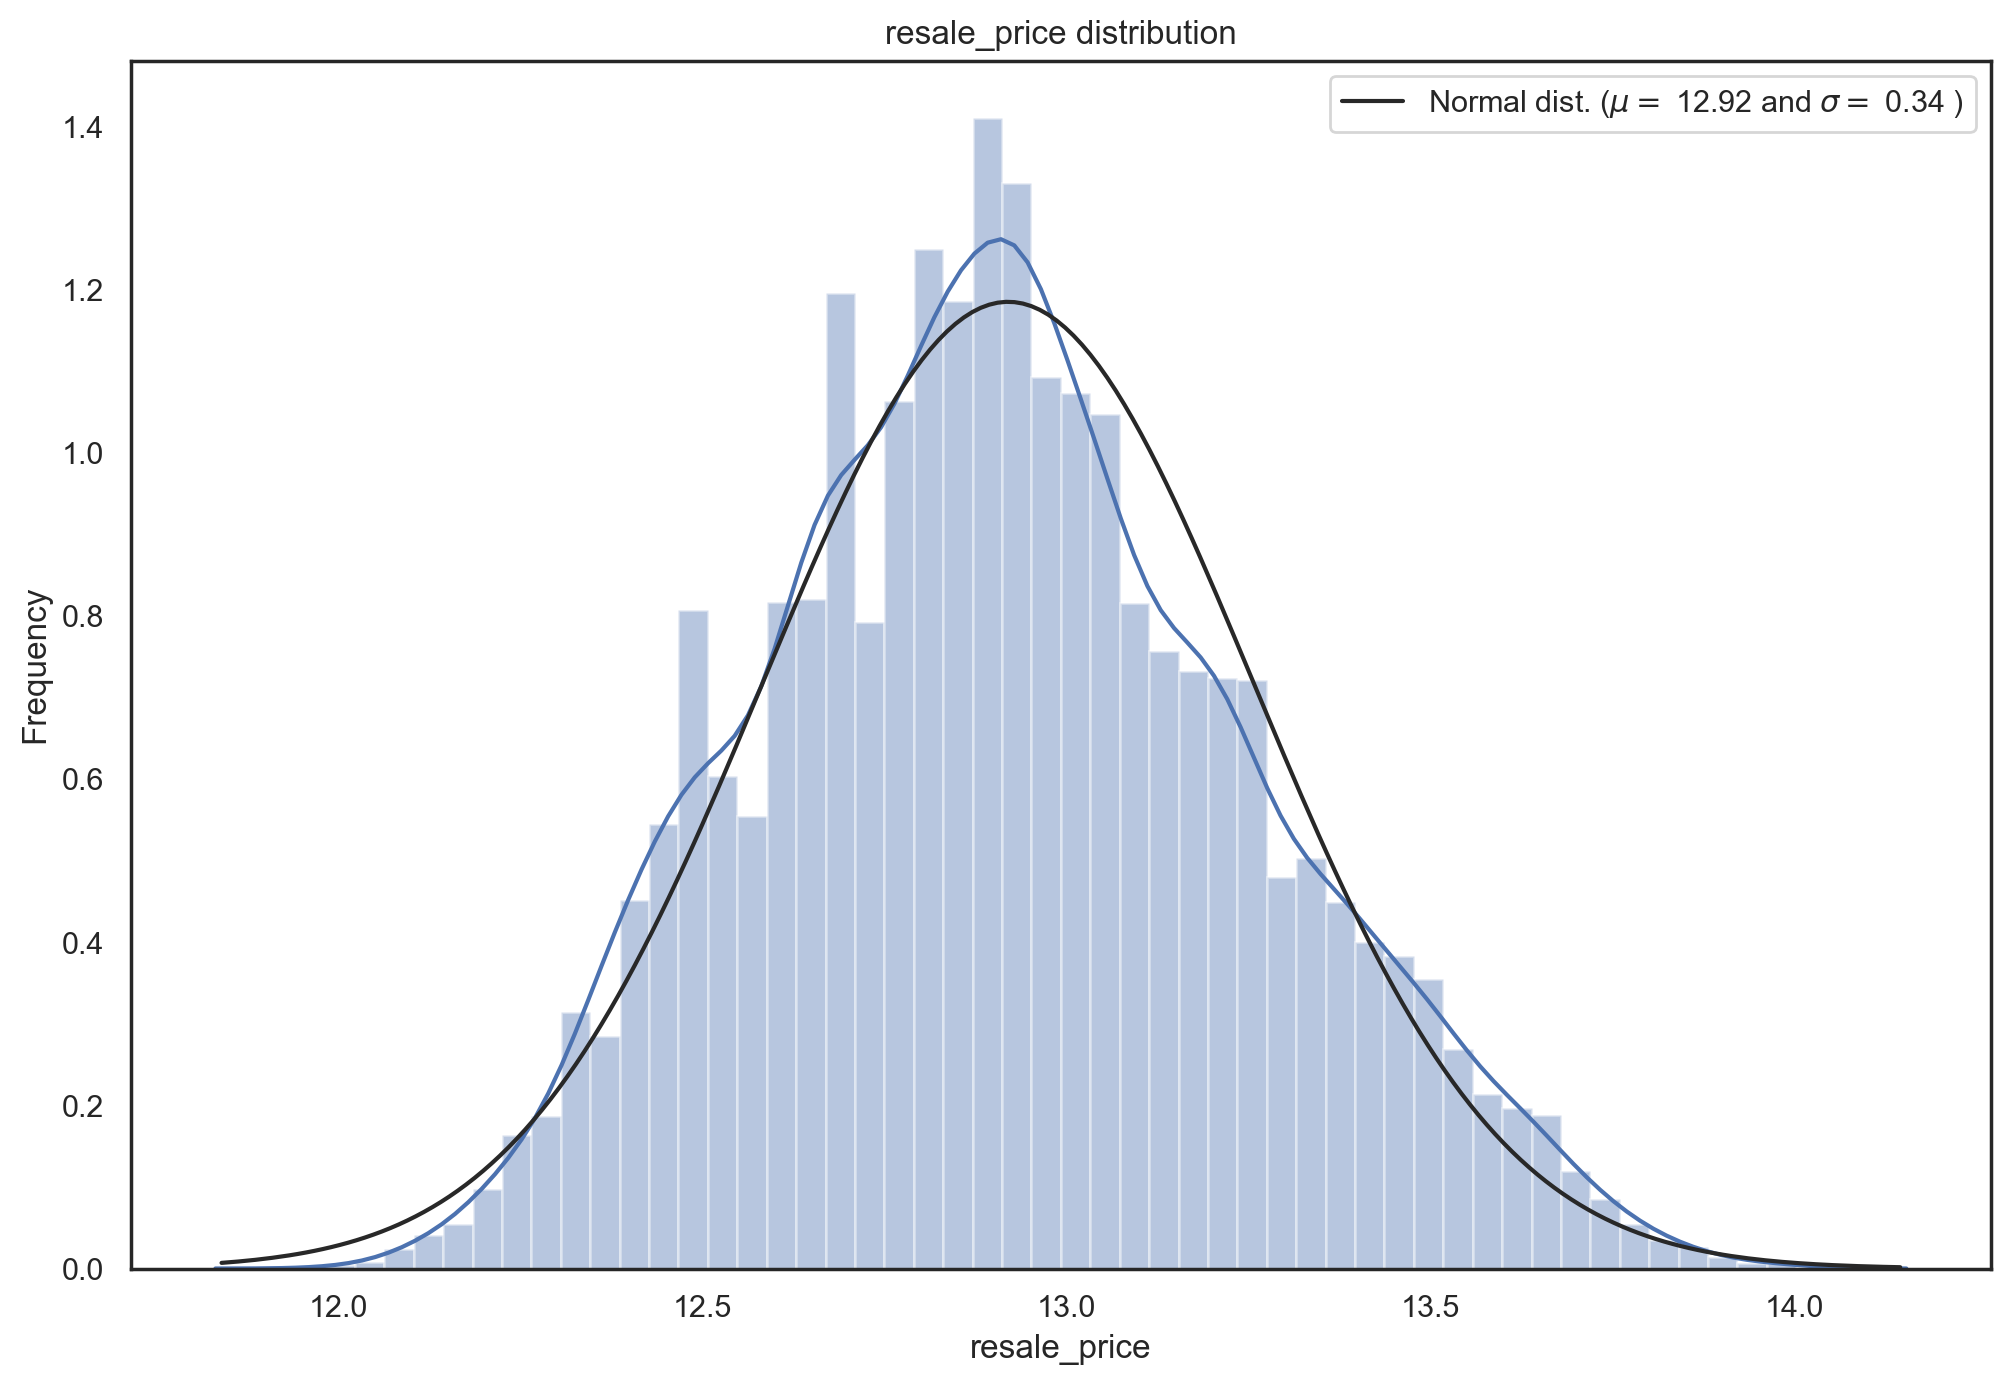

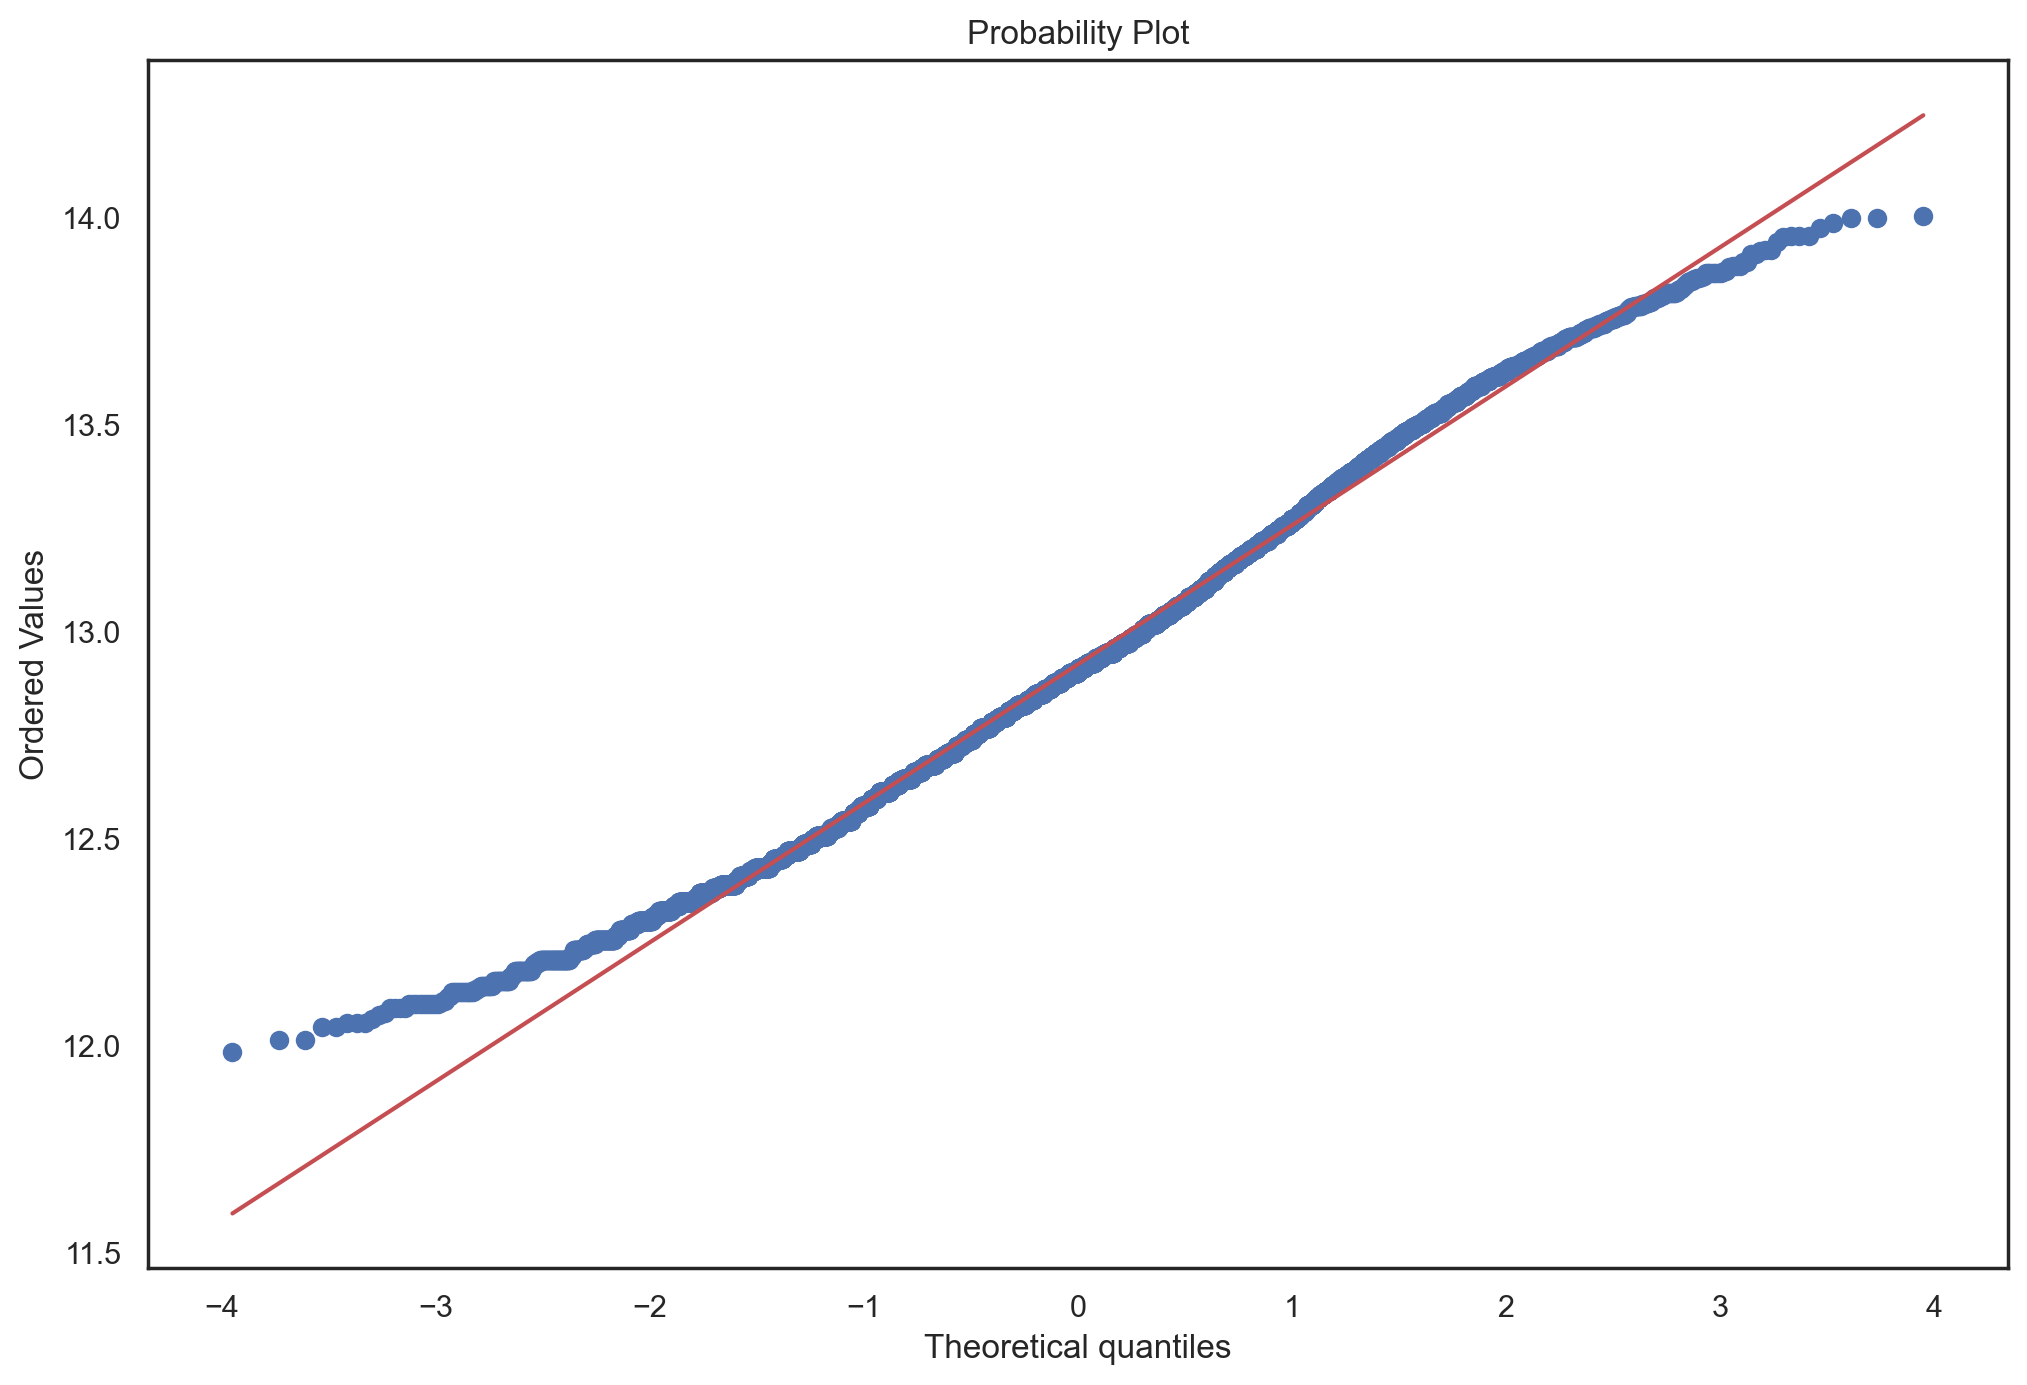

Skewness: 0.223794
Kurtosis: -0.299765


In [184]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["resale_price"] = np.log1p(train["resale_price"])

#Check the new distribution 
sns.distplot(train['resale_price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['resale_price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('resale_price distribution')

fig = plt.figure()
res = stats.probplot(train['resale_price'], plot=plt)
plt.show()

y_train = train.resale_price.values

print("Skewness: %f" % train['resale_price'].skew())
print("Kurtosis: %f" % train['resale_price'].kurt())

In [185]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skewed Features' :skewed_feats})
skewness.head()

,Skewed Features
nearest_sm_distance(km),2.190
nearest_primary_school(km),1.836
storey_range,1.753
nearest_secondary_school(km),1.671
nearest_mrt_distance(km),1.076


In [186]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
    all_data[feat] += 1

There are 12 skewed numerical features to Box Cox transform


In [187]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(22186, 572)


In [188]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [189]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [190]:
# Cross-validation with k-folds
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [191]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.5, n_estimators=7200,
                             reg_alpha=0.9, reg_lambda=0.6,
                             subsample=0.2,seed=42, silent=1,
                             random_state =7)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [192]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


Lasso score: 0.0995 (0.0013)

ElasticNet score: 0.0985 (0.0014)

Kernel Ridge score: 0.0891 (0.0011)

Gradient Boosting score: 0.0637 (0.0008)

[02:11:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:14:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:16:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\le

In [193]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [194]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print("Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Averaged base models score: 0.0824 (0.0010)



In [195]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(clf)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [196]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = model_xgb)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

[02:43:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:51:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:58:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

In [197]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [198]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

[03:25:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.0581398620602399


In [200]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

[03:30:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.04335442739581803


In [209]:
import re

train1 = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


In [210]:
model_lgb.fit(train1, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.0717559720306436


In [211]:
print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.10 + lgb_train_pred*0.20 ))

RMSLE score on train data:
0.056767742047076256


In [212]:
Stacked = 1/(0.0581398620602399)
XGBoost = 1/(0.04335442739581803)
LGBM = 1/(0.0717559720306436)
Sum = Stacked + XGBoost + LGBM
Stacked = Stacked/Sum
XGBoost = XGBoost/Sum
LGBM = LGBM/Sum
print(Stacked, XGBoost, LGBM)

0.317331314397324 0.42555282020019675 0.2571158654024794


In [213]:
print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*Stacked +
               xgb_train_pred*XGBoost + lgb_train_pred*LGBM))

RMSLE score on train data:
0.05128743587770052


In [214]:
ensemble = stacked_pred*Stacked + xgb_pred*XGBoost + lgb_pred*LGBM

In [215]:
ensemble

array([394014.5623453 , 431914.02089513, 344258.41560264, ...,
       265388.35121278, 271202.60836784, 534880.3971891 ])

In [216]:
sub = pd.DataFrame()
sub = x_test
# sub['Id'] = test_ID
sub['predicted_resale_Price'] = ensemble
sub['Assigned_resale_price']=x_test['resale_price']
sub['Predicted_Assigned_%_Diff'] = (abs(sub['Assigned_resale_price']-sub['predicted_resale_Price'])/sub['Assigned_resale_price'])*100
sub

,town,storey_range,floor_area_sqm,lease_commence_date,remaining_lease,resale_price,Latitude,Longtitude,nearest_mrt,nearest_mrt_distance(km),...,nearest_JC/MI,nearest_JC/MI(km),nearest_mixed_level,nearest_mixed_level(km),nearest_sm,nearest_sm_distance(km),flat_type_model,predicted_resale_Price,Assigned_resale_price,Predicted_Assigned_%_Diff
21265,PASIR RIS,01 TO 03,110.000,1989,69,400000.000,1.375,103.958,PASIR RIS MRT STATION,1.003,...,TAMPINES MERIDIAN JUNIOR COLLEGE,2.282,TEMASEK JUNIOR COLLEGE,6.743,RAW MARKET PTE. LTD.,0.321,4 ROOM Model A,394014.562,400000.000,1.496
13904,TAMPINES,01 TO 03,103.000,1985,65,445000.000,1.353,103.948,TAMPINES MRT STATION,0.339,...,TAMPINES MERIDIAN JUNIOR COLLEGE,2.901,TEMASEK JUNIOR COLLEGE,4.040,NTUC Fairprice Co-operative Ltd,0.371,4 ROOM Model A,431914.021,445000.000,2.941
8024,TAMPINES,13 TO 15,73.000,1984,64,350000.000,1.349,103.940,TAMPINES WEST MRT STATION,0.365,...,TAMPINES MERIDIAN JUNIOR COLLEGE,3.119,TEMASEK JUNIOR COLLEGE,3.362,COLD STORAGE SINGAPORE (1983) PTE LTD,0.522,3 ROOM Model A,344258.416,350000.000,1.640
153,BEDOK,10 TO 12,150.000,1985,65,670000.000,1.331,103.909,KAKI BUKIT MRT STATION,0.476,...,VICTORIA JUNIOR COLLEGE,3.010,TEMASEK JUNIOR COLLEGE,3.280,CHUA & NG PTE. LTD.,0.621,EXECUTIVE Maisonette,662695.512,670000.000,1.090
21319,PUNGGOL,13 TO 15,68.000,2016,96,385000.000,1.404,103.895,SOO TECK LRT STATION,0.255,...,TAMPINES MERIDIAN JUNIOR COLLEGE,5.584,MARIS STELLA HIGH SCHOOL,7.177,U STARS SUPERMARKET PTE. LTD.,0.245,3 ROOM Model A,373122.089,385000.000,3.085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12344,YISHUN,04 TO 06,73.000,1988,68,280000.000,1.420,103.835,KHATIB MRT STATION,0.371,...,YISHUN INNOVA JUNIOR COLLEGE,0.854,CHIJ ST. NICHOLAS GIRLS' SCHOOL,5.075,NTUC Fairprice Co-operative Ltd,0.294,3 ROOM Model A,274792.686,280000.000,1.860
19251,JURONG WEST,16 TO 18,133.000,2000,80,658000.000,1.343,103.705,BOON LAY MRT STATION,0.464,...,MILLENNIA INSTITUTE,4.177,RIVER VALLEY HIGH SCHOOL,0.432,NTUC Fairprice Co-operative Ltd,0.318,EXECUTIVE Premium Apartment,629527.056,658000.000,4.327
5659,QUEENSTOWN,07 TO 09,58.000,1967,47,285000.000,1.304,103.800,COMMONWEALTH MRT STATION,0.209,...,ANGLO-CHINESE JUNIOR COLLEGE,1.616,ANGLO-CHINESE SCHOOL (INDEPENDENT),2.177,SHENG SIONG SUPERMARKET PTE LTD,0.263,3 ROOM Standard,265388.351,285000.000,6.881
10410,ANG MO KIO,04 TO 06,74.000,1978,58,305000.000,1.371,103.837,ANG MO KIO MRT STATION,1.364,...,EUNOIA JUNIOR COLLEGE,1.046,CHIJ ST. NICHOLAS GIRLS' SCHOOL,0.429,COLD STORAGE SINGAPORE (1983) PTE LTD,0.391,3 ROOM New Generation,271202.608,305000.000,11.081


In [217]:
sub['Predicted_Assigned_%_Diff'].mean()

4.49630853947364